# FRL Fake News Capstone Notebook part 2

In [1]:
#import all needed libraries and perform required configuration setup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import tldextract
import string
import spacy
from spacy.lang import punctuation
import unicodedata  # might need to pip install unicodedate2 on aws sagemaker
from contractions import CONTRACTION_DICT # need to have the contractions.py file copied to your path
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams
from collections import defaultdict
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC 
from sklearn.gaussian_process import GaussianProcessClassifier 
from sklearn.gaussian_process.kernels import RBF 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier 
from sklearn.neural_network import MLPClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
import gensim
from gensim.models import word2vec
from gensim.models.fasttext import FastText
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import STOPWORDS


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='darkgrid',palette='Dark2',rc={'figure.figsize':(9,6),'figure.dpi':90})

punctuation = string.punctuation + '”' + '“' + '–' + '““' + "’’" + '”'
stopword = stopwords.words('english')
stopwords = set(STOPWORDS)
wordnet_lemmatizer = WordNetLemmatizer()

nlp = spacy.load('en',parse=True,tag=True, entity=True)
# if you get error from the above , you will need to install the following to stage the proper file:
#python -m spacy download en_core_web_sm
#python -m spacy download en

In [2]:
#set a random seed
seed = 500

## Reading in the precleaned fake news corpus 

In [3]:
# Import the data
df = pd.read_csv(r"C:\Users\lanre\Documents\data_science\cleaned_frl_fake2.csv")
df.head()

,Unnamed: 0,domain,type,content,scraped_at,title,label
0,7766484,nytimes.com,reliable,One month after a three-judge panel of a feder...,2018-02-11 00:42:14.935145+00:00,Appeal of Challenge to ‘No Child’ Law,real
1,6845267,www.yahoo.com,reliable,STOCKHOLM (Reuters) - Sweden will seek assuran...,2016-11-11 14:16:53.754000+00:00,Sweden seek assurances from Trump regarding de...,real
2,8102733,nytimes.com,reliable,"But this week, the bus’s practices gained wide...",2018-02-11 00:45:31.225957+00:00,"At Front of Brooklyn Bus, a Clash of Religious...",real
3,6917956,www.yahoo.com,reliable,BEIRUT (AP) — The Latest on developments in Sy...,2016-11-08 03:28:07.118000+00:00,The Latest: Turkey: Use of Kurds against IS 'n...,real
4,6965379,www.sfgate.com,reliable,Hot-shooting Tennessee Tech routs Alabama A&M ...,2016-11-18 22:38:10.550000+00:00,Hot-shooting Tennessee Tech routs Alabama A&M ...,real


## Dropping the unneeded columns 

In [4]:
# list of columns to drop from the datasets
cols_to_drop = ['Unnamed: 0', 'type']

# drop the columns and check the memory usage
df.drop(cols_to_drop, axis=1, inplace=True)
df.head()

,domain,content,scraped_at,title,label
0,nytimes.com,One month after a three-judge panel of a feder...,2018-02-11 00:42:14.935145+00:00,Appeal of Challenge to ‘No Child’ Law,real
1,www.yahoo.com,STOCKHOLM (Reuters) - Sweden will seek assuran...,2016-11-11 14:16:53.754000+00:00,Sweden seek assurances from Trump regarding de...,real
2,nytimes.com,"But this week, the bus’s practices gained wide...",2018-02-11 00:45:31.225957+00:00,"At Front of Brooklyn Bus, a Clash of Religious...",real
3,www.yahoo.com,BEIRUT (AP) — The Latest on developments in Sy...,2016-11-08 03:28:07.118000+00:00,The Latest: Turkey: Use of Kurds against IS 'n...,real
4,www.sfgate.com,Hot-shooting Tennessee Tech routs Alabama A&M ...,2016-11-18 22:38:10.550000+00:00,Hot-shooting Tennessee Tech routs Alabama A&M ...,real


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1788000 entries, 0 to 1787999
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   domain      object
 1   content     object
 2   scraped_at  object
 3   title       object
 4   label       object
dtypes: object(5)
memory usage: 68.2+ MB


## Changing dtypes of some columns

In [6]:
df['domain'] = df['domain'].astype('category')
df['scraped_at'] = pd.to_datetime(df['scraped_at'], utc=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1788000 entries, 0 to 1787999
Data columns (total 5 columns):
 #   Column      Dtype              
---  ------      -----              
 0   domain      category           
 1   content     object             
 2   scraped_at  datetime64[ns, UTC]
 3   title       object             
 4   label       object             
dtypes: category(1), datetime64[ns, UTC](1), object(3)
memory usage: 58.0+ MB


In [7]:
# checking missing values
def missing_value(df):
    """" Function to calculate the number and percent of missing values in a dataframe"""
    total = df.isnull().sum().sort_values(ascending=False)
    percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
    missing_value = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    return missing_value

In [8]:
missing_value(df)

,Total,Percent
label,0,0.0
title,0,0.0
scraped_at,0,0.0
content,0,0.0
domain,0,0.0


### Extract day name from `scraped_at` column

In [9]:
df['day_name'] = df['scraped_at'].dt.day_name()
df.head(3)

,domain,content,scraped_at,title,label,day_name
0,nytimes.com,One month after a three-judge panel of a feder...,2018-02-11 00:42:14.935145+00:00,Appeal of Challenge to ‘No Child’ Law,real,Sunday
1,www.yahoo.com,STOCKHOLM (Reuters) - Sweden will seek assuran...,2016-11-11 14:16:53.754000+00:00,Sweden seek assurances from Trump regarding de...,real,Friday
2,nytimes.com,"But this week, the bus’s practices gained wide...",2018-02-11 00:45:31.225957+00:00,"At Front of Brooklyn Bus, a Clash of Religious...",real,Sunday


## Clean up the domain and check the unique domains

In [10]:
def extract_domain(url):
    """
    Extract domain name from fld url
    """
    info = tldextract.extract(url)
    return info.domain

In [11]:
df['domain'] = df['domain'].astype(str).apply(extract_domain)
df.head(3)

,domain,content,scraped_at,title,label,day_name
0,nytimes,One month after a three-judge panel of a feder...,2018-02-11 00:42:14.935145+00:00,Appeal of Challenge to ‘No Child’ Law,real,Sunday
1,yahoo,STOCKHOLM (Reuters) - Sweden will seek assuran...,2016-11-11 14:16:53.754000+00:00,Sweden seek assurances from Trump regarding de...,real,Friday
2,nytimes,"But this week, the bus’s practices gained wide...",2018-02-11 00:45:31.225957+00:00,"At Front of Brooklyn Bus, a Clash of Religious...",real,Sunday


## Unique domain counts

<AxesSubplot:title={'center':'Distribution of the number of articles from first 25 domains'}>

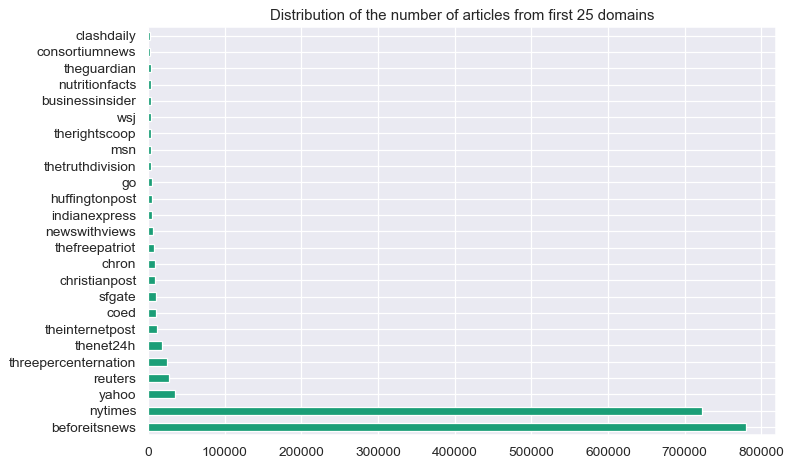

In [12]:
df.domain.value_counts(ascending=False).head(25).plot.barh(title='Distribution of the number of articles from first 25 domains')

<AxesSubplot:title={'center':'Distribution of domain with fake label'}>

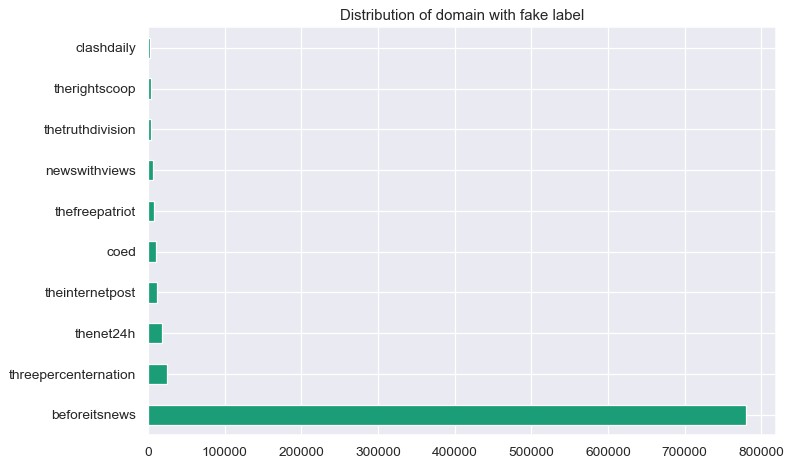

In [13]:
# Class fake
f_df = df[df['label']=='fake']
f_df['domain'].value_counts(ascending=False).head(10).plot.barh(title='Distribution of domain with fake label')

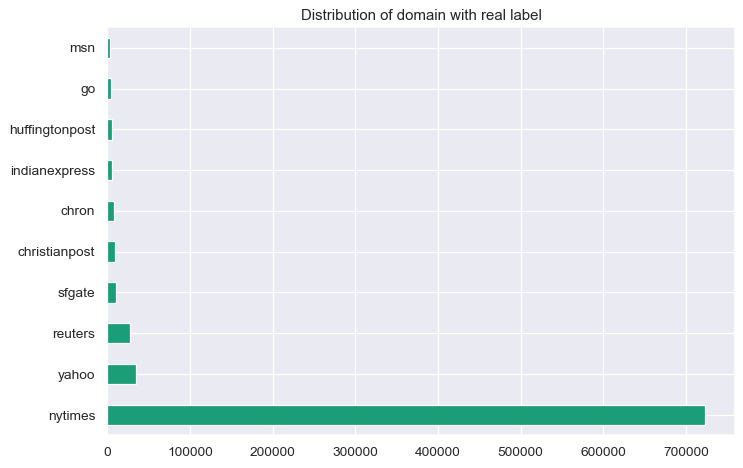

In [14]:
r_df = df[df['label']=='real']
r_df['domain'].value_counts(ascending=False).head(10).plot.barh(title='Distribution of domain with real label');

In [15]:
del f_df
del r_df

### Unique count of day of the week

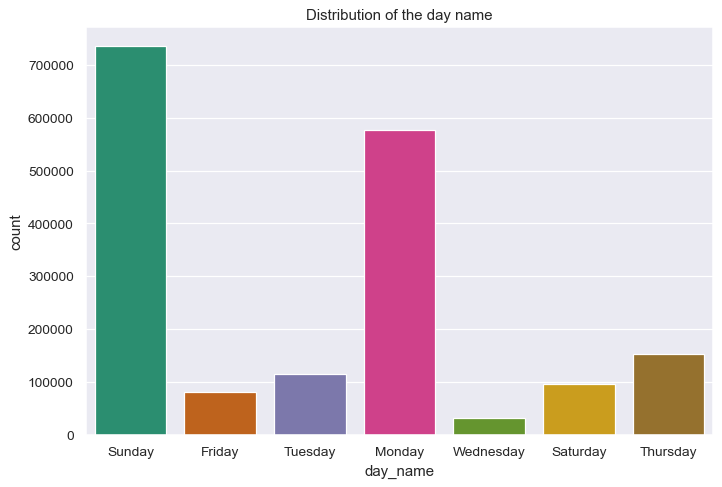

In [16]:
sns.countplot(x='day_name', data=df).set_title('Distribution of the day name');

## Distribution of type of news article in the  label columns of the corpus

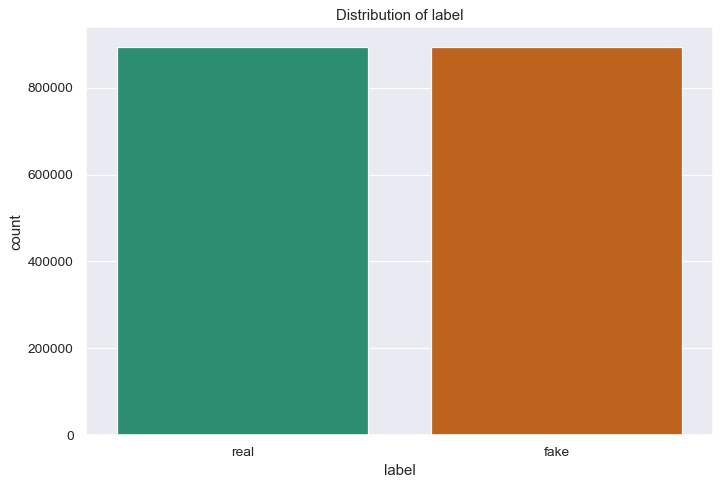

In [17]:
sns.countplot(x='label', data=df).set_title('Distribution of label');

## Explore fundamental characteristics of text in the title and content columns

In [18]:
#Taking a look at some few rows in the title
for index,text in enumerate(df['title'][0:5]):
    print('Title %d:\n'%(index+1),text, '\n')

Title 1:
 Appeal of Challenge to ‘No Child’ Law 

Title 2:
 Sweden seek assurances from Trump regarding defense agreement 

Title 3:
 At Front of Brooklyn Bus, a Clash of Religious and Women’s Rights 

Title 4:
 The Latest: Turkey: Use of Kurds against IS 'naive' 

Title 5:
 Hot-shooting Tennessee Tech routs Alabama A&M 95-61 - SFGate 



In [19]:
#Now, looking at the content*
for index,text in enumerate(df['content'][0:5]):
    print('Content %d:\n'%(index+1),text, '\n')

Content 1:
 One month after a three-judge panel of a federal appeals court revived a legal challenge to the federal No Child Left Behind law, Education Secretary Margaret Spellings said she would ask the United States Court of Appeals for the Sixth Circuit, in Cincinnati, to convene a larger panel to reconsider that ruling. In its 2-to-1 ruling on Jan. 7, the Sixth Circuit said that school districts in Michigan and several other states had been justified in their 2005 suit that argued the law required them to pay for testing and other programs without providing sufficient federal money. 

Content 2:
 STOCKHOLM (Reuters) - Sweden will seek assurances from U.S. president-elect Donald Trump that a recently signed defense cooperation agreement will be honored by the new administration and on his commitment to NATO, Defence Minister Peter Hultqvist said. After years of rising tensions with Russia in the Baltic region, Sweden and the United States signed a declaration of intent in June to in

# Text Data Preprocessing

## Cleaning up the content column by removing all the noises

**The folllowing functions will be used to remove noise such as accented characters, whitespaces and spacial characters, digits, punctuations**

In [20]:
def remove_special_characters(text): 
    """
    Removes special characters from the text document
    """
    # define the pattern to keep. You can check the regex using this url https://regexr.com/
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
    return re.sub(pat, '', text)

def remove_extra_whitespace_tabs(text): 
    """
    Removes extra whitespaces and remove_extra_whitespace_tabs
    """
    #pattern = r'^\s+$|\s+$'
    pattern = r'^\s*|\s\s*'
    return re.sub(pattern, ' ', text).strip()

def remove_digits(text): 
    """
    Remove all digits from the text document
     take string input and return a clean text without numbers.
        Use regex to discard the numbers.
    """
    result = ''.join(i for i in text if not i.isdigit()).lower()
    return ' '.join(result.split())

def remove_newlines(text): 
    """
    Remove newline characters from the text document
    """
    return text.replace('\\n', ' ').replace('\\r', ' ').replace('\n', ' ').replace('\r', ' ').replace('\\', ' ')

#normalize to the NFKD (Normalization Form Compatibility Decomposition) form
#that present in the Unicode standard to remain compatible with other encodings
def remove_accented_chars(text): 
    """
    Removes accented characters from the test
    """
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

#expands contractions found in the text
def expand_contractions(text, contraction_mapping=CONTRACTION_DICT):

    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

# replace punctuation characters with spaces
def replace_punctuation(text):
    filters = string.punctuation + '”' + '“' + '–' 
    translate_dict = dict((c, " ") for c in filters)   
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    return text

# Remove stopwords and remove words with 2 or less characters
def stops_letters(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stopword:
            result.append(token)
            
    return " ".join(result)

#Removes any word that starts with either http or https
def remove_urls (vTEXT):
    #vTEXT = re.sub('http://\S+|https://\S+', '', vTEXT,flags=re.MULTILINE)
    vTEXT = re.sub('http[s]?://\S+', '', vTEXT,flags=re.MULTILINE)
    return(vTEXT)
#Remove words that starts with www
def remove_www (vTEXT):
    vTEXT = re.sub('www\S+', '', vTEXT,flags=re.MULTILINE)
    return(vTEXT)


In [21]:
%%time
# Apply the functions to the dataframe

# Step 1 - convert the text to lower case
df['content']=df['content'].apply(lambda x: x.lower())
df['title']=df['title'].apply(lambda x: x.lower())
df['day_name']=df['day_name'].apply(lambda x: x.lower())

#step 2 - Remove URLS
df['content']=df['content'].apply(remove_urls)
df['title'] = df['title'].apply(remove_urls)

#step 3 - Remove www
df['content']=df['content'].apply(remove_www)
df['title'] = df['title'].apply(remove_www)

# Step 4 - remove special charcaters
df['content']=df['content'].apply(remove_special_characters)
df['title'] = df['title'].apply(remove_special_characters)

#step 5 - Remove whitespaces and tabs
df['content']=df['content'].apply(remove_extra_whitespace_tabs)
df['title'] = df['title'].apply(remove_extra_whitespace_tabs)

#step 6 - remove newlines and tabs
df['content'] = df['content'].apply(remove_newlines)
df['title'] = df['title'].apply(remove_newlines)

# step 7 - Remove digits
df['content']=df['content'].apply(remove_digits)
df['title'] = df['title'].apply(remove_digits)

#step 8 - remove accented characters
df['content']=df['content'].apply(remove_accented_chars)
df['title'] = df['title'].apply(remove_accented_chars)

#step 9 - Expand contractions
df['content']=df['content'].apply(expand_contractions)

#step 10 - Replace punctuations with spaces 
df['content']= df['content'].apply(replace_punctuation)
df['title'] = df['title'].apply(replace_punctuation)

#step 11 - Remove stopwords, tokenize and remove words with 3 letters or less
df['content']= df['content'].apply(stops_letters)
df['title'] = df['title'].apply(stops_letters)


Wall time: 4h 53min 11s


## View the datasets after noise removal

In [22]:
for index,text in enumerate(df['title'][10:15]):
    print('Title %d:\n'%(index+1),text, '\n')

Title 1:
 china threat 

Title 2:
 surprisingly simple thanksgiving dish plays 

Title 3:
 world briefing europe netherlands bank profit rises 

Title 4:
 democratic party chief reproaches bush 

Title 5:
 paid notice deaths lowenheim henry 



In [23]:
for index,text in enumerate(df['content'][10:15]):
    print('Content %d:\n'%(index+1),text, '\n')

Content 1:
 vein fury erupted country weeks earlier reports japanese businessmen engaged orgy chinese prostitutes southern city zhuhai chinese rage hypocritical country hundreds thousands prostitutes blatantly wares zhengzhou year army prostitutes practically battered hotel room door cowered inside chinese recounting history hysterical rape nanjing brutal need exaggerate appalled witness killing john rabe death toll miner searle bates estimated civilians soldiers killed chinese delegate league nations time civilian toll communist chinese newspaper period newsletter sign continue reading main story verify robot clicking invalid email address reenter select newsletter subscribe sign agree receive occasional updates special offers york timess products services thank subscribing error occurred later view york times newsletters china proclaims based accounts stand little scrutiny killed hyperbole abuses history denial japanese rightists rape nanjing nurtures nationalism defining china victi

In [24]:
for index,text in enumerate(df['content'][0:5]):
    print('Content %d:\n'%(index+1),text, '\n')

Content 1:
 month threejudge panel federal appeals court revived legal challenge federal child left education secretary margaret spellings said united states court appeals sixth circuit cincinnati convene larger panel reconsider ruling ruling sixth circuit said school districts michigan states justified suit argued required testing programs providing sufficient federal money 

Content 2:
 stockholm reuters sweden seek assurances presidentelect donald trump recently signed defense cooperation agreement honored administration commitment nato defence minister peter hultqvist said years rising tensions russia baltic region sweden united states signed declaration intent june increase defense cooperation deal includes joint exercises adaptation technologies practices joint natostandard actions election campaign created long series question marks hultqvist told reuters assume contracts agreements countries signed united states stand election campaign trump threatened abandon allies europe spe

## Frequencies of words

**The `counter` function from the `collections` library will be used to count and store the occurrences of each word in a list of tuples. This is a very useful function when we deal with word-level analysis in natural language processing**

In [25]:
from nltk.corpus import stopwords
from collections import Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:20]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    sns.barplot(x=y,y=x)


###  Plot of words in the title

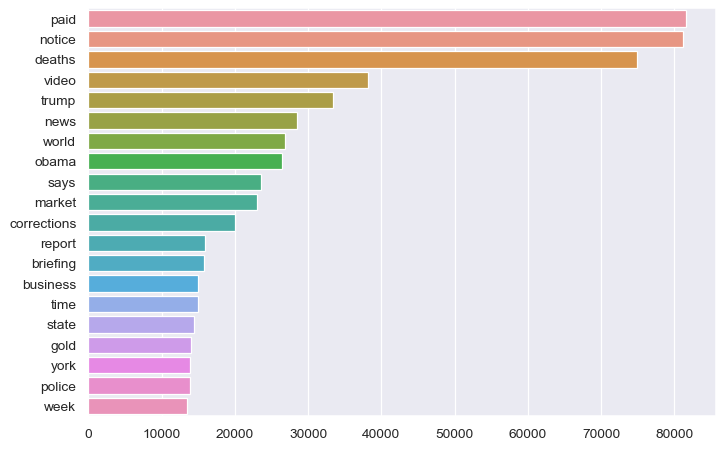

In [26]:
plot_top_non_stopwords_barchart(df['title']);

**Decided to just continue the preprocessing and come back to doing EDA and word frequencies analysis after saving the preprocessed datasets**

## Lemmatize the title and content columns

In [27]:
def lemmatized_word(text):
    """
    lemmatize the text so as to get its root form eg: functions,funtionality as function
    """
    word_tokens = nltk.word_tokenize(text)
    lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in word_tokens]
    return  " ".join(lemmatized_word)


In [28]:
df['content'] = df['content'].apply(lemmatized_word)
df['title'] = df['title'].apply(lemmatized_word)
df.head(3)

,domain,content,scraped_at,title,label,day_name
0,nytimes,month threejudge panel federal appeal court re...,2018-02-11 00:42:14.935145+00:00,appeal challenge child,real,sunday
1,yahoo,stockholm reuters sweden seek assurance presid...,2016-11-11 14:16:53.754000+00:00,sweden seek assurance trump defense agreement,real,friday
2,nytimes,week bus practice gained widespread publicity ...,2018-02-11 00:45:31.225957+00:00,brooklyn clash religious woman right,real,sunday


In [29]:
for index,text in enumerate(df['content'][0:5]):
    print('Content %d:\n'%(index+1),text, '\n')

Content 1:
 month threejudge panel federal appeal court revived legal challenge federal child left education secretary margaret spelling said united state court appeal sixth circuit cincinnati convene larger panel reconsider ruling ruling sixth circuit said school district michigan state justified suit argued required testing program providing sufficient federal money 

Content 2:
 stockholm reuters sweden seek assurance presidentelect donald trump recently signed defense cooperation agreement honored administration commitment nato defence minister peter hultqvist said year rising tension russia baltic region sweden united state signed declaration intent june increase defense cooperation deal includes joint exercise adaptation technology practice joint natostandard action election campaign created long series question mark hultqvist told reuters assume contract agreement country signed united state stand election campaign trump threatened abandon ally europe spend defense praised russi

# Saving the preprocessed datasets into a csv file

In [30]:
df.to_csv(r"C:\Users\lanre\Documents\data_science\preprocessed_frl_fake.csv", index=False)

### Reading back the saved datasets to make sure it saved correctly

In [31]:
dfa = pd.read_csv(r"C:\Users\lanre\Documents\data_science\preprocessed_frl_fake.csv")
dfa.head()

,domain,content,scraped_at,title,label,day_name
0,nytimes,month threejudge panel federal appeal court re...,2018-02-11 00:42:14.935145+00:00,appeal challenge child,real,sunday
1,yahoo,stockholm reuters sweden seek assurance presid...,2016-11-11 14:16:53.754000+00:00,sweden seek assurance trump defense agreement,real,friday
2,nytimes,week bus practice gained widespread publicity ...,2018-02-11 00:45:31.225957+00:00,brooklyn clash religious woman right,real,sunday
3,yahoo,beirut latest development syria backed kurdish...,2016-11-08 03:28:07.118000+00:00,latest turkey kurd naive,real,tuesday
4,sfgate,hotshooting tennessee tech rout alabama publis...,2016-11-18 22:38:10.550000+00:00,hotshooting tennessee tech rout alabama sfgate,real,friday


**Examining the preprocessed data**

In [32]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1788000 entries, 0 to 1787999
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   domain      object
 1   content     object
 2   scraped_at  object
 3   title       object
 4   label       object
 5   day_name    object
dtypes: object(6)
memory usage: 81.8+ MB


**Examinining the original datasets to make sure no data was lost during the preprocessing**

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1788000 entries, 0 to 1787999
Data columns (total 6 columns):
 #   Column      Dtype              
---  ------      -----              
 0   domain      object             
 1   content     object             
 2   scraped_at  datetime64[ns, UTC]
 3   title       object             
 4   label       object             
 5   day_name    object             
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 81.8+ MB
